# Self-Driving Car Engineer Nanodegree


## Project: **Advenced Lane Finding** 
***

Advanced Lane Finding Project
The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.for this project.

---
**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Camera Calibration

In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

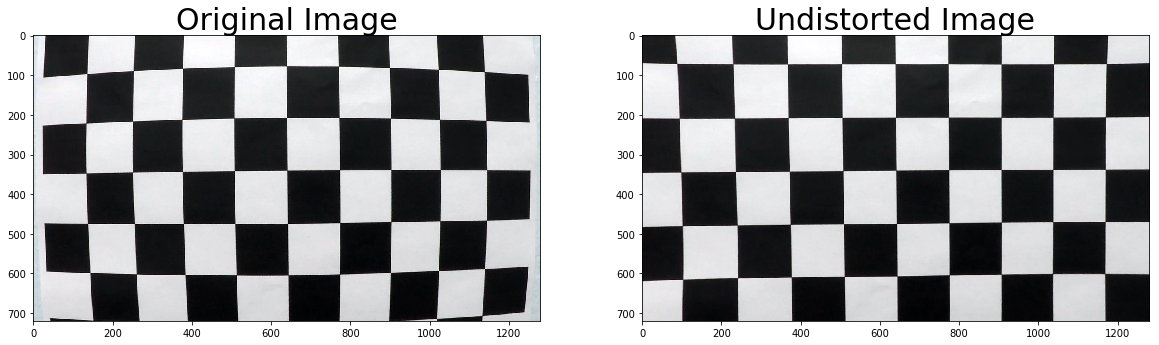

In [38]:
#import pickle
#%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistortion an image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/undist_calibration1.jpg',dst)


# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (single images)
## Ideas for Lane Detection Pipeline
**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

## Helper Functions

In [55]:


def distortion_remover(img):
    """ 
        function:Removing the camera distortion from a image
        aurge1: a RGB image (with camera distortion)
        return: a RGB image (withoute camera distortion)
    """ 
    with open("output_images/dist_pickle.p", "rb") as f:
    # The pickle protocol version used is detected automatically, so we do not have to specify it.
        # Load camera calibration data
        dist_pickle = pickle.load(f)
        # Extract the calibration data
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
        
    # Undistortion an image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img


def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=="x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient=="y":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Apply threshold
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    #abs_sobel = np.absolute([sobelx,sobely])
    abs_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Apply threshold
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(sobelx*sobelx)
    abs_sobely = np.sqrt(sobely*sobely)
    abs_sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_angle = np.arctan2(abs_sobely, abs_sobelx)

    # Apply threshold
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(sobel_angle)
    dir_binary[(sobel_angle >= thresh[0]) & (sobel_angle <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return dir_binary

def HLS_thresh(image, channel="s_channel", hls_thresh=(170, 255)):
    """
        function: HLS channel converte RGB to binary image
        arg1: original image
        arg2: channel select
        arg3: threshold value
        return: binary image with hls channel
    """
    # extract H or L or S channel
    # 1) Convert to HSV color space 
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # 2) Separate the V channel
    if channel == "h_channel":
        hls_channel_img = hsv[:,:,0] # h_channel
    if channel == "l_channel":
        hls_channel_img = hsv[:,:,1] # l_channel
    if channel == "s_channel":
        hls_channel_img = hsv[:,:,2] # s_channel
    
    # 3) Apply threshold
    hls_binary = np.zeros_like(hls_channel_img)
    hls_binary[(hls_channel_img >= hls_thresh[0]) & (hls_channel_img <= hls_thresh[1])] = 1
    
    # 4) Return this mask as your binary_output image
    return hls_binary


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


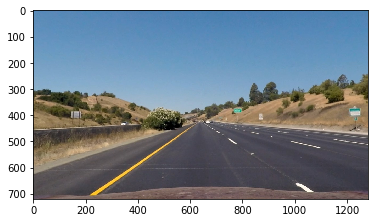

In [36]:
#reading in an image
raw_image = mpimg.imread('test_images/straight_lines1.jpg')

image = cv2.undistort(raw_image, mtx, dist, None, mtx)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### 1) Provide a distortion-corrected image

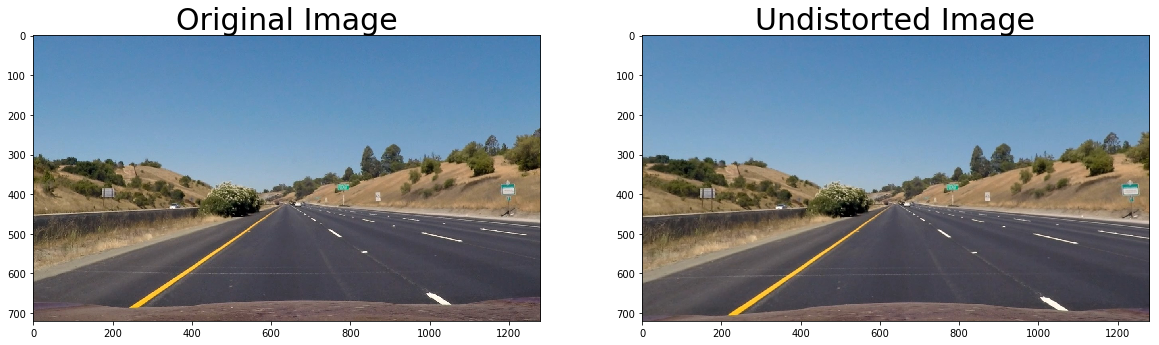

In [53]:
#reading in an image
raw_image = mpimg.imread('test_images/straight_lines1.jpg')

image = distortion_remover(raw_image)
#image = cv2.undistort(raw_image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

### 2) Extract a binary image

In [58]:
# Read an image file
image = mpimg.imread('test_images/test6.jpg')

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Apply each defference color channels
S_binary   = HLS_thresh(image, channel="s_channel", hls_thresh=(170, 255))
L_binary   = HLS_thresh(image, channel="l_channel", hls_thresh=(170, 255))

# Get combined image
combined = np.zeros_like(dir_binary)
combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

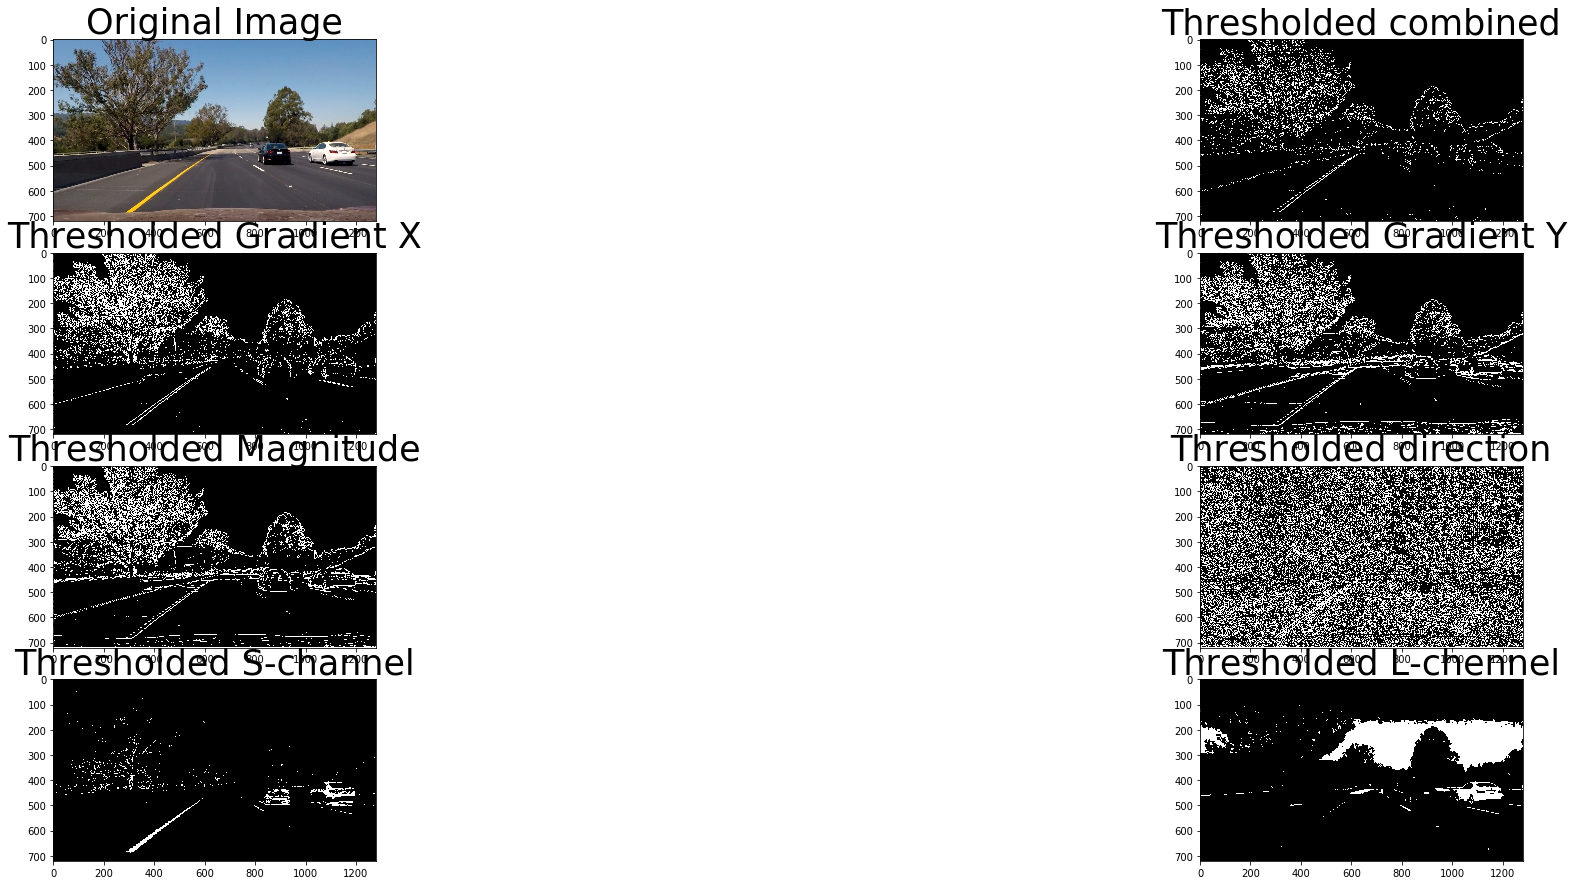

In [59]:
# Plot the result
f, ( (ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7,ax8) ) = plt.subplots(4, 2, figsize=(24*4/3, 9*4/3))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=35)

ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded combined', fontsize=35)

ax3.imshow(gradx_binary, cmap='gray')
ax3.set_title('Thresholded Gradient X', fontsize=35)

ax4.imshow(grady_binary, cmap='gray')
ax4.set_title('Thresholded Gradient Y', fontsize=35)

ax5.imshow(mag_binary, cmap='gray')
ax5.set_title('Thresholded Magnitude', fontsize=35)

ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('Thresholded direction', fontsize=35)

ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('Thresholded direction', fontsize=35)

ax7.imshow(S_binary, cmap='gray')
ax7.set_title('Thresholded S-channel', fontsize=35)

ax8.imshow(L_binary, cmap='gray')
ax8.set_title('Thresholded L-chennel', fontsize=35)


#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 3) Perfrom a perspective image

### 4) Identify lane line pixels

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In this process thet target file is solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


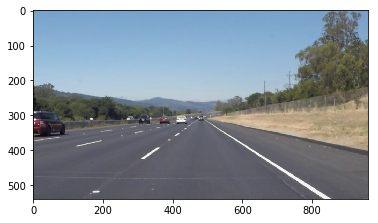

In [4]:
import os
images = os.listdir("test_images/")

#print(images)
src_img = images[1]
print("In this process thet target file is "+src_img)
#reading in an image
img = mpimg.imread("test_images/"+src_img)

#printing out some stats and plotting
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

The taerget images are 
['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']
In this process thet target file is solidWhiteCurve.jpg


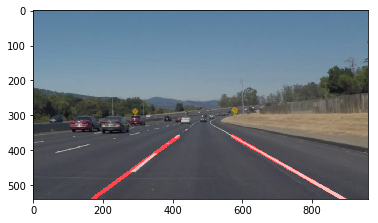

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#Init the file path
#file_path = "test_images_output/"
file_path = "test_images/"

images = os.listdir(file_path)
print("The taerget images are ")
print(images)

#Select the image
src_img = images[0]
print("In this process thet target file is "+src_img)
#reading in an image
img = mpimg.imread(file_path+src_img)

#printing out some stats and plotting
#print('This image is:', type(img), 'with dimensions:', img.shape)
#plt.imshow(img)
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#Get the size og image
img_size = img.shape

# Gray scale
gray = grayscale(img)

#Applies a Gaussian Noise kernel
kernel_size = 5
gauss = gaussian_blur(gray, kernel_size)

#Applies the Canny transform
high_threshold = 150
low_threshold = 30
edge = canny(gauss, low_threshold, high_threshold)

#Applies an image mask.
left_bottom = (0, img_size[0])
right_bottom = (img_size[1], img_size[0])
apex = (img_size[1]/2, img_size[0]/2+25)
vertices = np.array([[left_bottom, right_bottom, apex]], dtype=np.int32)
edge_masked = region_of_interest(edge, vertices)
#plt.imshow(edge_masked)

#Applies a hough transformation
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 80  # minimum number of pixels making up a line
max_line_gap = 20   # maximum gap in pixels between connectable line segments
line_image = np.copy(img)*0 # creating a blank to draw lines on

line_image = hough_lines(edge_masked, rho, theta, threshold, min_line_len, max_line_gap)

# Make the outpout image
lines_edges = weighted_img(line_image, img, α=0.8, β=1., λ=0.)
plt.imshow(lines_edges)

# Save the outpout image
plt.savefig("test_images_output/"+"result_"+src_img)

## Build a Lane Finding Pipeline for debug and making picture

The taerget images are 
['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']
In this process thet target file is solidWhiteRight.jpg


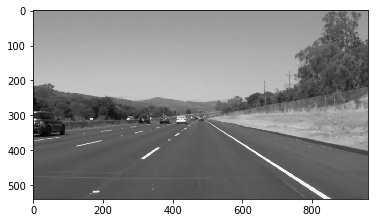

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import numpy as np
import os
#Init the file path
#file_path = "test_images_output/"
file_path = "test_images/"

images = os.listdir(file_path)
print("The taerget images are ")
print(images)

# Select the image
src_img = images[1]
print("In this process thet target file is "+src_img)
#reading in an image
img = mpimg.imread(file_path+src_img)

#Get the size og image
img_size = img.shape

# Gray scale
gray = grayscale(img)
plt.imshow(gray, cmap='gray')

# Save the outpout image
plt.savefig("test_images_output/"+"gray_"+src_img)

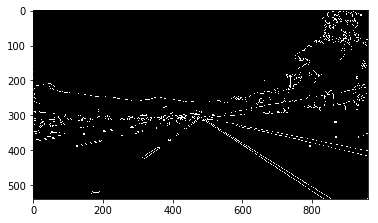

In [8]:
#Applies a Gaussian Noise kernel
kernel_size = 5
gauss = gaussian_blur(gray, kernel_size)
plt.imshow(gauss, cmap='gray')

#Applies the Canny transform
high_threshold = 120
low_threshold = 30
edge = canny(gauss, low_threshold, high_threshold)
plt.imshow(edge, cmap='gray')

# Save the outpout image
plt.savefig("test_images_output/"+"edge_"+src_img)

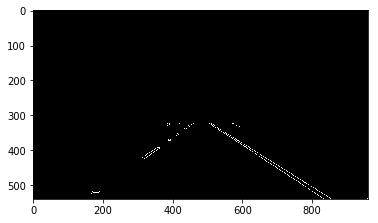

In [9]:
#Applies an image mask
roi_center_height = img_size[0]*(8/10)
#left_bottom = (0, img_size[0])
#right_bottom = (img_size[1], img_size[0])
#apex = (img_size[1]/2, roi_center_height)
#vertices = np.array([[left_bottom, right_bottom, apex]], dtype=np.int32)
vertices = np.array([[(0,img_size[0]),(img_size[1]*(4/10),img_size[0]*(6/10)), (img_size[1]*(6/10),img_size[0]*(6/10)), (img_size[1],img_size[0])]], dtype=np.int32)

edge_masked = region_of_interest(edge, vertices)

# Make the outpout image
plt.imshow(edge_masked, cmap='gray')

# Save the outpout image
plt.savefig("test_images_output/"+"edge_masked_"+src_img)

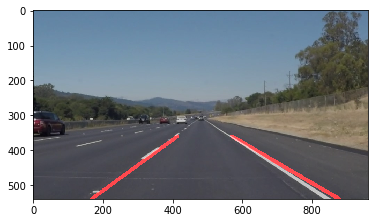

In [10]:
#Applies a hough transformation
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180   # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 80  # minimum number of pixels making up a line
max_line_gap = 70   # maximum gap in pixels between connectable line segments
line_image = np.copy(img)*0 # creating a blank to draw lines on

line_image = hough_lines(edge_masked, rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(line_image, cmap='gray')

# Make the outpout image
lines_edges = weighted_img(line_image, img, α=0.8, β=1., λ=0.)
plt.imshow(lines_edges)

# Save the outpout image
plt.savefig("test_images_output/"+"lines_edges_"+src_img)

## Test for Pipeline on Videos

In this cell, Drawing lanes over video!
I evaluate my solution on 3 provided videos:

`project.mp4`

`challenge.mp4`

`harder_challenge.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #Reset the input
    img = image
    
    #Get the size og image
    img_size = img.shape

    # Gray scale
    gray = grayscale(img)

    #Applies a Gaussian Noise kernel
    kernel_size = 5
    gauss = gaussian_blur(gray, kernel_size)

    #Applies the Canny transform
    high_threshold = 120
    low_threshold = 30
    edge = canny(gauss, low_threshold, high_threshold)

    #Applies an image mask.
    vertices = np.array([[(0,img_size[0]),(img_size[1]*(4/10),img_size[0]*(6/10)), (img_size[1]*(6/10),img_size[0]*(6/10)), (img_size[1],img_size[0])]], dtype=np.int32)
    edge_masked = region_of_interest(edge, vertices)

    #Applies a hough transformation
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 80  # minimum number of pixels making up a line
    max_line_gap = 70   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    line_image = hough_lines(edge_masked, rho, theta, threshold, min_line_len, max_line_gap)

    #Make the outpout image
    lines_edges = weighted_img(line_image, img, α=0.8, β=1., λ=0.)
    #plt.imshow(lines_edges)
    result = lines_edges
    
    return result

## 1) Project.mp4

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 33.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.62 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

## 2) challenge.mp4

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:23<00:00, 30.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 24.6 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## 3) Harder_challenge.mp4

In [17]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:17<00:00, 14.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 19.3 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))